In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import svd
import matplotlib.pyplot as plt

In [2]:
def decompose_matrix(matrix : np.ndarray):
    """
    Decompõe a matriz em U, Sigma e Vt.
    """
    return svd(matrix, full_matrices=False)

def spoiled_matrix(matrix : np.ndarray, pos : tuple, choices : np.ndarray):
    """
    Cria uma cópia B da matriz de input.
    "Estraga" o valor na posição "pos". Valores ficam no intervalo [0.5, 5] com incremento de 0.5
    Devolve B.
    """
    B = matrix.copy()
    random_val = np.random.choice(choices)
    B[*pos] = random_val
    return B

def random_pos(matrix : np.ndarray):
    """
    Gera uma posição aleatória da matriz, com a condição que ela seja diferente de 0.
    """
    if isinstance(matrix, np.ndarray):
        idxs = np.argwhere(matrix)
        i = np.random.choice(idxs.shape[0]-1)
        return idxs[i]
    else:
        raise TypeError
    
def get_smaller(eigenvalues : np.ndarray, N : int):
    """
    Devolve os índices dos N menores autovalores.
    """
    return np.argsort(eigenvalues)[:N]

def predict_val(matrix : np.ndarray):
    """
    Decompõe a matriz passada no argumento, e então tenta prever o valor real.
    """
    U, s, Vt = decompose_matrix(matrix)
    smaller = get_smaller(s, 10) # Gera os índices dos menores 10 autovalores
    s[smaller] *= 0 # Remove o ruído da matriz

    return U @ np.diag(s) @ Vt



In [3]:
df = pd.read_csv('ratings_small.csv') # Lê arquivo de dados
df = pd.pivot(df, columns='movieId', index='userId', values='rating') # Cria tabela pivot (userId x movieId)
A = df.fillna(0).to_numpy()

In [4]:
n_exp = 1000 # Número de experimentos
errors = [] # Lista de erros em relação ao valor real (previsão - real)

choices = np.linspace(0.5, 5, 10) # Possíveis escolhas pelo modelo
for i in range(n_exp):
    pos = random_pos(A)

    initial_val = A[*pos]
    spoiled = spoiled_matrix(A, pos, choices) # Cria matriz "estragada"

    spoiled_pred = predict_val(spoiled) # Tenta prever o valor real do valor "estragado"

    errors += [abs(spoiled_pred[*pos] - A[*pos])] # Adiciona erro absoluto entre o previsto e real

In [14]:
rounded_errors = [round(err, 1) for err in errors]

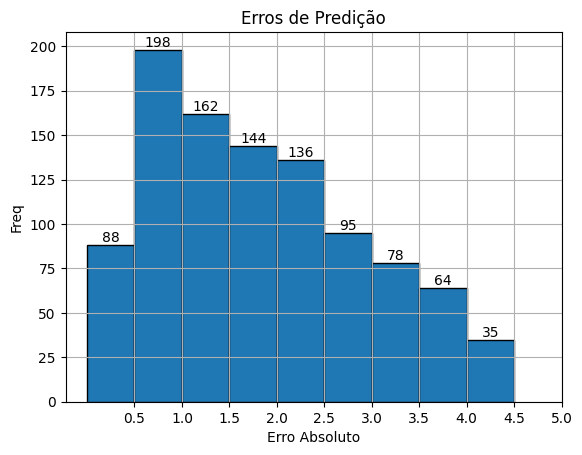

In [19]:
values, bins, bars = plt.hist(rounded_errors, bins=9, edgecolor='black')
plt.title('Erros de Predição')
plt.xlabel('Erro Absoluto')
plt.ylabel('Freq')
plt.xticks([0] + choices)
plt.bar_label(bars, fontsize=10, color='black')
plt.grid()
plt.show()

# Conclusão

In [22]:
mean_error = np.average(rounded_errors)
median_error = np.median(rounded_errors)
maior_que_2 = len([e for e in rounded_errors if e >= 2])
print(f'Média : {mean_error:.2f}\nMediana : {median_error:.2f}\nErros maiores que 2 : {maior_que_2}')

Média : 1.59
Mediana : 1.50
Erros maiores que 2 : 408


Nosso grupo chegou na conclusão que não seria possível utilizar este algoritmo em produção, uma vez que a média e a mediana são 1.5 ou mais, o que é um valor muito alto para uma avaliação que vai de 0 a 5. Além disso, 40.8% dos erros são maiores que 2. Assim sendo, há uma margem de erro muito alta dos valores previstos em relação às notas reais.

Talvez com uma redução de ruído maior as previsões sejam eficientes, mas mesmo assim o código necessita muito processamento, fazendo com que estas previsões levem muito tempo para serem feitas em larga escala.